# Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Constants

In [2]:
input_width = 150
input_height = 150

train_epochs = 100
learning_rate = 0.001

train_batch_size = 14
validation_batch_size = 16

train_steps = 6
validation_steps = 1

checkpoint_path = "checkpoints/convolutional_neural_network/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_frequency = 1

train_dir = 'train3'
validation_dir = 'val3'

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')

validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')

# Configuration

### Model Configuration 

The images will go into the model as `150x150` color images. The architecture of the model has three `convolution + ReLU + max-pooling` modules and a fully connected layer stacked on top of each other. Each convolution extracts `3x3` filters, and each max-polling layer uses a `2x2` window. Dropout is added before the final classification layer to reduce overfitting.

In [3]:
img_input = layers.Input(shape=(input_width, input_height, 3))

# First convolution extracts 16 filters
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map in order to add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden nodes
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model
model = Model(img_input, output)

# Print architecture of model
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________

### Training Configuration

Train model with the `binary_crossentropy` loss function, use the `rmsprop` optimizer, and monitor accuracy, recall, and precision during training. Configure checkpoints to save weights of the model.

In [87]:
# Configure training specifications
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=learning_rate), metrics=[
    'acc', 
    Recall(name='recall'),
    Precision(name='precision')])

# Configure checkpoints
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=checkpoint_frequency)

# Data Preprocessing

Create data generators to read pictures and feed them to the network. Resize all images to be `150x150` pixels. Normalize data by making pixel values in range `[0, 1]` instead of `[0, 225]`. Augment training images by applying the following random transformations:
- `rotation_range` is for randomly rotating the image.
- `width_shift` and `height_shift` are for randomly translating pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally.
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [88]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(input_width, input_height),
        batch_size=train_batch_size,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(input_width, input_height),
        batch_size=validation_batch_size,
        class_mode='binary')

Found 84 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Training

In [89]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_steps,  # training images = batch_size * steps
      epochs=train_epochs,
      callbacks=[cp_callback],
      validation_data=validation_generator,
      validation_steps=validation_steps,  # validation images = batch_size * steps
      verbose=2)

Epoch 1/100

Epoch 00001: saving model to checkpoints/convolutional_neural_network/cp-0001.ckpt
6/6 - 3s - loss: 2.1284 - acc: 0.4286 - recall: 0.7143 - precision: 0.4545 - val_loss: 0.6872 - val_acc: 0.5625 - val_recall: 0.1250 - val_precision: 1.0000
Epoch 2/100

Epoch 00002: saving model to checkpoints/convolutional_neural_network/cp-0002.ckpt
6/6 - 2s - loss: 0.7175 - acc: 0.3929 - recall: 0.3810 - precision: 0.3902 - val_loss: 0.6894 - val_acc: 0.4375 - val_recall: 0.8750 - val_precision: 0.4667
Epoch 3/100

Epoch 00003: saving model to checkpoints/convolutional_neural_network/cp-0003.ckpt
6/6 - 2s - loss: 0.6912 - acc: 0.5357 - recall: 0.5714 - precision: 0.5333 - val_loss: 0.6944 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 4/100

Epoch 00004: saving model to checkpoints/convolutional_neural_network/cp-0004.ckpt
6/6 - 2s - loss: 0.7044 - acc: 0.4762 - recall: 0.4048 - precision: 0.4722 - val_loss: 0.6922 - val_acc: 0.5000 - val_recall: 1.0000 - val_precis

6/6 - 2s - loss: 0.5789 - acc: 0.6905 - recall: 0.5714 - precision: 0.7500 - val_loss: 0.8303 - val_acc: 0.4375 - val_recall: 0.7500 - val_precision: 0.4615
Epoch 34/100

Epoch 00034: saving model to checkpoints/convolutional_neural_network/cp-0034.ckpt
6/6 - 2s - loss: 0.6415 - acc: 0.6429 - recall: 0.5476 - precision: 0.6765 - val_loss: 0.6594 - val_acc: 0.5000 - val_recall: 0.3750 - val_precision: 0.5000
Epoch 35/100

Epoch 00035: saving model to checkpoints/convolutional_neural_network/cp-0035.ckpt
6/6 - 2s - loss: 0.6085 - acc: 0.6429 - recall: 0.5952 - precision: 0.6579 - val_loss: 0.6776 - val_acc: 0.4375 - val_recall: 0.2500 - val_precision: 0.4000
Epoch 36/100

Epoch 00036: saving model to checkpoints/convolutional_neural_network/cp-0036.ckpt
6/6 - 3s - loss: 0.8326 - acc: 0.6071 - recall: 0.5714 - precision: 0.6154 - val_loss: 0.6646 - val_acc: 0.6250 - val_recall: 0.3750 - val_precision: 0.7500
Epoch 37/100

Epoch 00037: saving model to checkpoints/convolutional_neural_netwo

Epoch 66/100

Epoch 00066: saving model to checkpoints/convolutional_neural_network/cp-0066.ckpt
6/6 - 2s - loss: 0.5219 - acc: 0.7024 - recall: 0.7381 - precision: 0.6889 - val_loss: 0.8486 - val_acc: 0.6250 - val_recall: 0.2500 - val_precision: 1.0000
Epoch 67/100

Epoch 00067: saving model to checkpoints/convolutional_neural_network/cp-0067.ckpt
6/6 - 2s - loss: 0.5348 - acc: 0.7262 - recall: 0.6190 - precision: 0.7879 - val_loss: 0.5706 - val_acc: 0.6875 - val_recall: 0.6250 - val_precision: 0.7143
Epoch 68/100

Epoch 00068: saving model to checkpoints/convolutional_neural_network/cp-0068.ckpt
6/6 - 2s - loss: 0.4273 - acc: 0.7857 - recall: 0.7619 - precision: 0.8000 - val_loss: 0.6772 - val_acc: 0.6875 - val_recall: 0.5000 - val_precision: 0.8000
Epoch 69/100

Epoch 00069: saving model to checkpoints/convolutional_neural_network/cp-0069.ckpt
6/6 - 2s - loss: 0.5864 - acc: 0.7738 - recall: 0.7619 - precision: 0.7805 - val_loss: 0.7081 - val_acc: 0.7500 - val_recall: 0.5000 - val_pr

6/6 - 2s - loss: 0.4405 - acc: 0.7976 - recall: 0.8333 - precision: 0.7778 - val_loss: 0.6237 - val_acc: 0.6875 - val_recall: 0.6250 - val_precision: 0.7143
Epoch 99/100

Epoch 00099: saving model to checkpoints/convolutional_neural_network/cp-0099.ckpt
6/6 - 2s - loss: 0.3585 - acc: 0.8452 - recall: 0.7619 - precision: 0.9143 - val_loss: 0.6265 - val_acc: 0.6875 - val_recall: 0.6250 - val_precision: 0.7143
Epoch 100/100

Epoch 00100: saving model to checkpoints/convolutional_neural_network/cp-0100.ckpt
6/6 - 2s - loss: 0.4006 - acc: 0.8214 - recall: 0.8095 - precision: 0.8293 - val_loss: 0.6808 - val_acc: 0.8125 - val_recall: 0.6250 - val_precision: 1.0000


# Plot Metrics

Plot the training/validation loss, accuracy, recall, and precision collected during training.

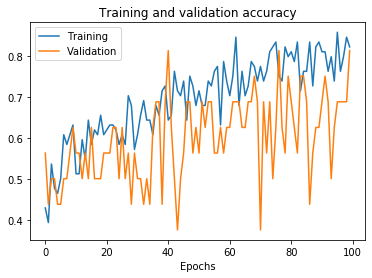

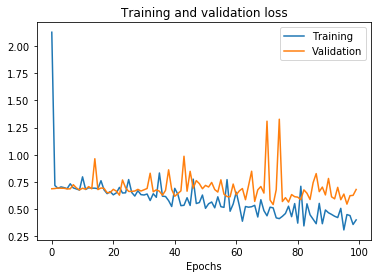

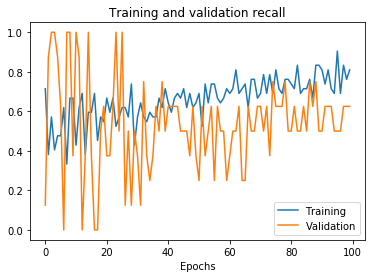

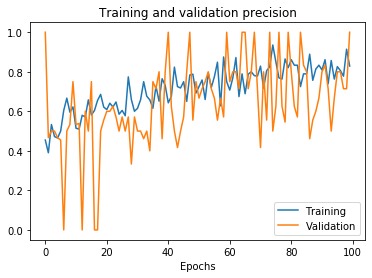

In [90]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of loss results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve a list of recall results on training and validation data
# sets for each training epoch
recall = history.history['recall']
val_recall = history.history['val_recall']

# Retrieve a list of loss precision on training and validation data
# sets for each training epoch
precision = history.history['precision']
val_precision = history.history['val_precision']

# Get number of epochs
epochs = range(len(acc))

%matplotlib inline

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

# Plot training and validation recall per epoch
plt.plot(epochs, recall, label='Training')
plt.plot(epochs, val_recall, label='Validation')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

# Plot training and validation precision per epoch
plt.plot(epochs, precision, label='Training')
plt.plot(epochs, val_precision, label='Validation')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.legend()

# Load Checkpoint

Select a checkpoint from training to use to classify images.

In [4]:
load_checkpoint = 'checkpoints/convolutional_neural_network/cp-0100.ckpt'
model.load_weights(load_checkpoint)

# View Predictions

Show test images along with the model's prediction compared to the expected value.

Found 16 images belonging to 2 classes.
Accuracy = 0.8125


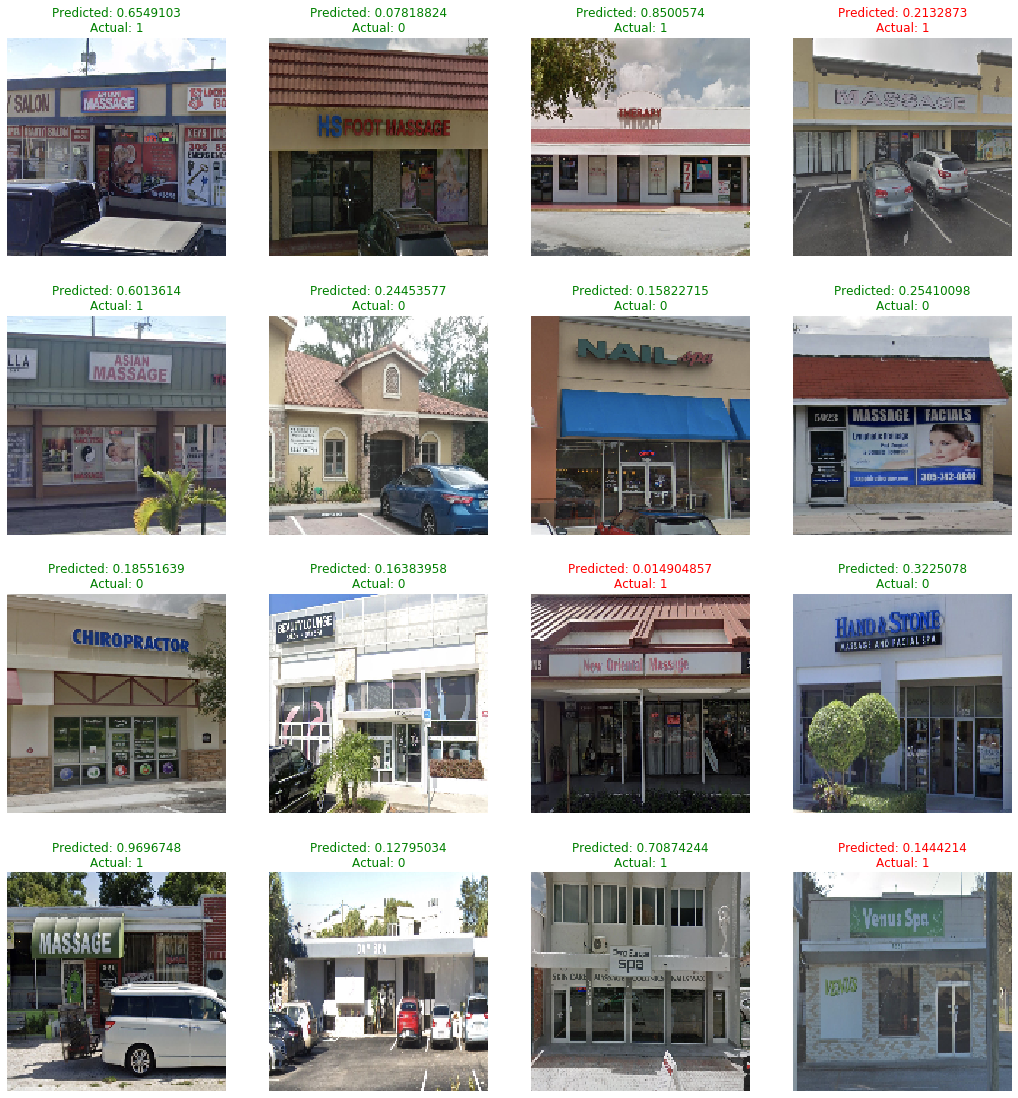

In [107]:
predict_datagen = ImageDataGenerator(rescale=1./255)
image_data = predict_datagen.flow_from_directory(
        validation_dir,
        target_size=(input_width, input_height))

for image_batch, label_batch in image_data:
    break
    
result_batch = model.predict(image_batch)

plt.figure(figsize=(18,20))
plt.subplots_adjust(hspace=0.1)
correct = 0
for n in range(len(image_batch)):
    plt.subplot(4,4,n+1)
    plt.imshow(image_batch[n])
    label = 0
    if label_batch[n][1] == 1:
        label = 1
    color = 'r'
    if label == round(result_batch[n][0]):
        color = 'g'
        correct += 1
    title = 'Predicted: ' + str(result_batch[n][0]) + '\nActual: ' + str(label)
    title_obj = plt.title(title)
    plt.setp(title_obj, color=color)
    plt.axis('off')

print('Accuracy =', correct/len(image_batch))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


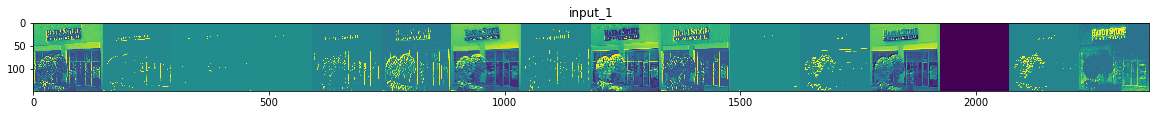

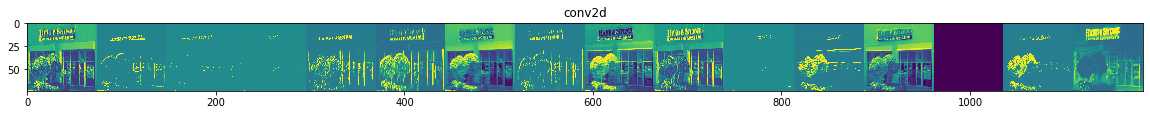

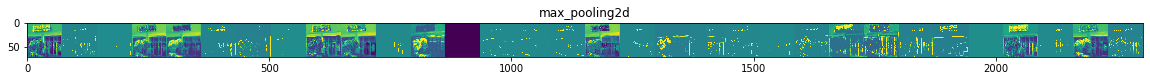

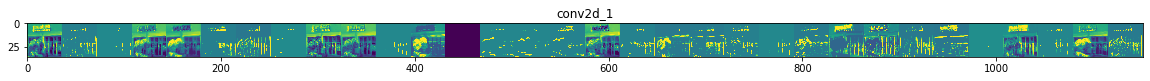

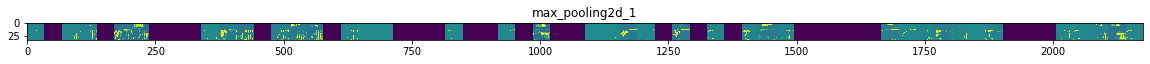

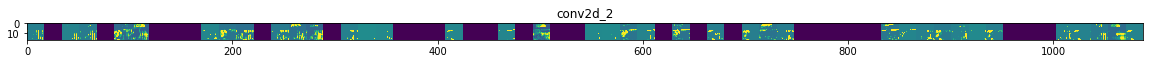

In [9]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

img_path = 'val3/0/36492.jpg'

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')